# Titanic Classification

Research Domain Knowledge: Titanic Kapal Super Britania Raya yang tenggelam karena menabrak sebuah gunung es di Samudra Atlantik Utara pada 15 April 1912 dan mengakibatkan kematian 1.514 penumpang. 

## Import Libraries

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [73]:
df = pd.read_csv('titanic.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Understanding Every Feature in Dataset:

1. **PassengerId**: ID unik untuk setiap penumpang.
2. **Survived**: Status kelangsungan hidup (1 = selamat, 0 = tidak selamat).
3. **Pclass**: Kelas tiket penumpang (1 = kelas satu, 2 = kelas dua, 3 = kelas tiga).
4. **Name**: Nama lengkap penumpang.
5. **Sex**: Jenis kelamin penumpang (male = pria, female = wanita).
6. **Age**: Usia penumpang (dalam tahun).
7. **SibSp**: Jumlah saudara kandung dan pasangan yang bepergian bersama.
8. **Parch**: Jumlah orang tua dan anak yang bepergian bersama.
9. **Ticket**: Nomor tiket penumpang.
10. **Fare**: Tarif tiket.
11. **Cabin**: Nomor kabin penumpang.
12. **Embarked**: Pelabuhan tempat penumpang naik kapal:
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

## Exploratory Data Analysis

In [74]:
df.drop(columns='PassengerId', inplace=True)

In [75]:
# Informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [76]:
# Cek nilai kosong
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

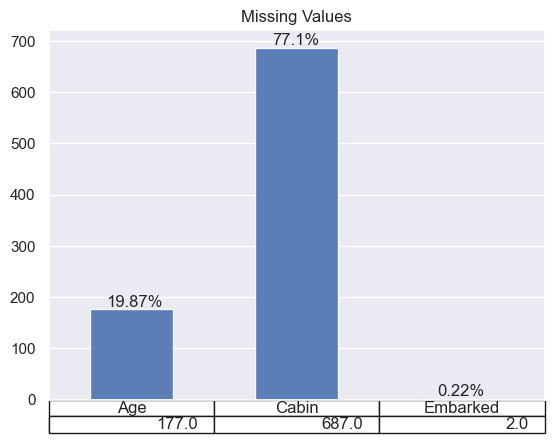

In [77]:
# Persentase Variabel dengan Missing Values
rows_length = df.shape[0]
fields_with_nan_length = df.isna().sum().where(lambda x : x > 0).dropna()

ax = fields_with_nan_length \
.plot(kind='bar', alpha=0.9, title='Missing Values', table=True)
ax.xaxis.set_visible(False)

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+5, \
            str(round((i.get_height()/rows_length)*100, 2))+'%')

### Handling Missing Values


Jika nilai kosong lebih dari 30%, maka kita bisa menghilangkan kolom tersebut. Jika tidak bisa kita gunakan imputasi statistik

In [78]:
df = df.drop(columns='Cabin', axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [79]:
# Mengganti nilai kosong variabel 'Age' dengan rata-rata
df['Age'].fillna(df['Age'].mean(), inplace=True)
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    2
dtype: int64

In [80]:
# Menemukan indeks nilai terbanyak dari variabel 'Embarked'
print(df['Embarked'].mode())

0    S
Name: Embarked, dtype: object


In [81]:
# 0 adalah indeksnya
print(df['Embarked'].mode()[0])

S


In [82]:
# Mengganti nilai kosong variabel 'Embarked' dengan modus
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [83]:
df.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [84]:
# Nilai statistik data
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [85]:
# Menghitung nilai orang yang selamat and tidak selamat
df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

<Axes: xlabel='Survived', ylabel='count'>

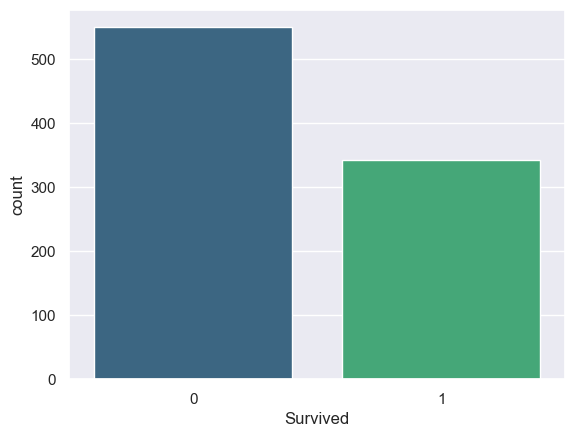

In [86]:
# visualisasi survived
sns.set()
sns.countplot(x='Survived', data=df, palette='viridis')

In [87]:
# Menghitung jenis kelamin penumpang
df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

<Axes: xlabel='Sex', ylabel='count'>

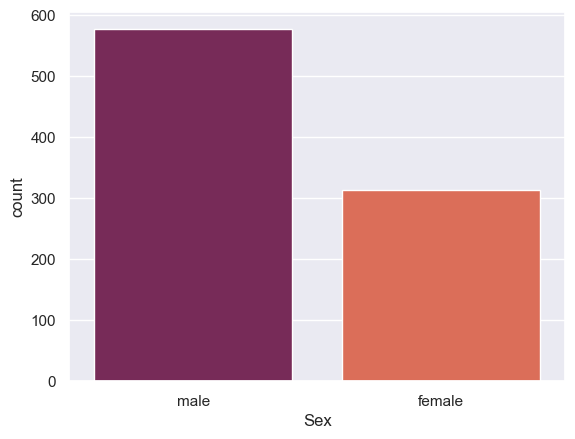

In [88]:
# visualisasi gender
sns.set()
sns.countplot(x='Sex', data=df, palette='rocket')

<Axes: xlabel='Sex', ylabel='count'>

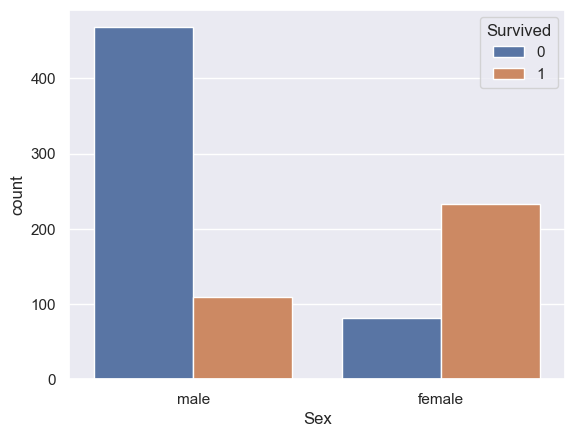

In [89]:
# Orang yang selamat berdasarkan jenis kelamin
sns.countplot(x="Sex", hue="Survived", data=df)

<Axes: xlabel='Pclass', ylabel='count'>

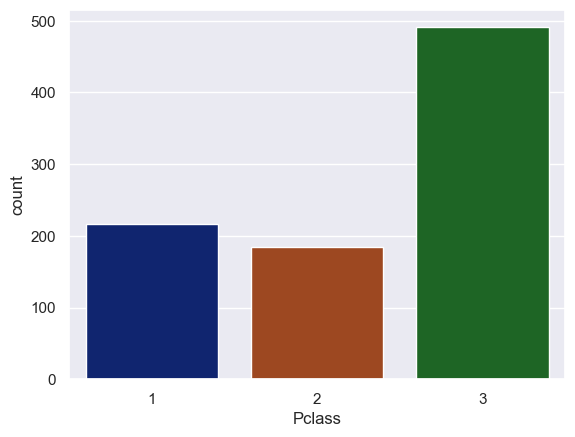

In [90]:
# Creating a Count plot for Pclass Column 
sns.countplot(x="Pclass", data=df, palette='dark')

<Axes: xlabel='Pclass', ylabel='count'>

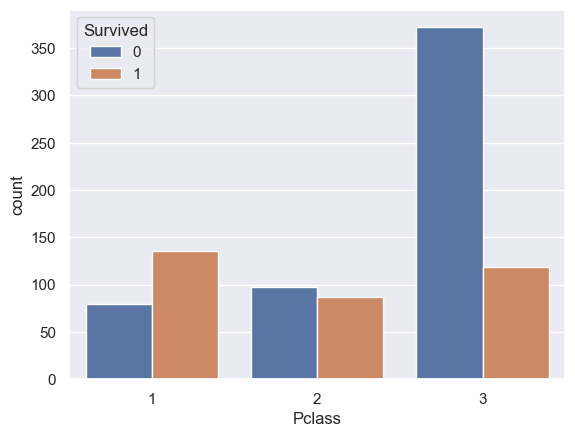

In [91]:
# Menghitung orang yang selamat berdasarkan kelas penumpang
sns.countplot(x="Pclass", hue="Survived", data=df)

### Encoding the Categorical Columns

In [92]:
df["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [93]:
df["Embarked"].value_counts()

Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

In [94]:
# Ubah Nilai Kategorik menjadi Numerik
df.replace({'Sex':{'male':0, 'female':1}, 
                      'Embarked':{'S':0, 'C':1, 'Q':2}}, inplace=True)

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0


### Feature Selection

Text(0.5, 1.0, 'Korelasi Antar Fitur')

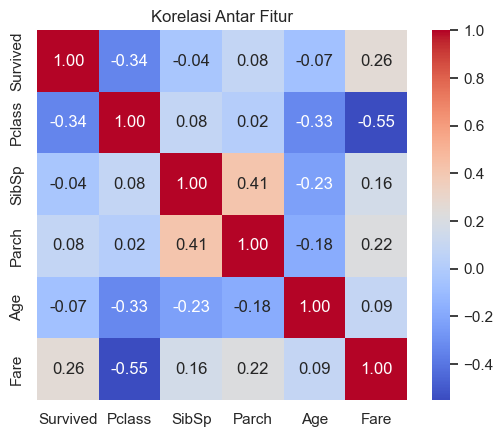

In [95]:
sns.heatmap(df[['Survived','Pclass', 'SibSp', 'Parch', 'Age', 'Fare']].corr(),square=True, annot = True, fmt = '.2f', cmap = 'coolwarm').set_title('Korelasi Antar Fitur')

In [96]:
X = df.drop(columns=["Name", "Ticket", "Survived"], axis=1)
Y = df['Survived']

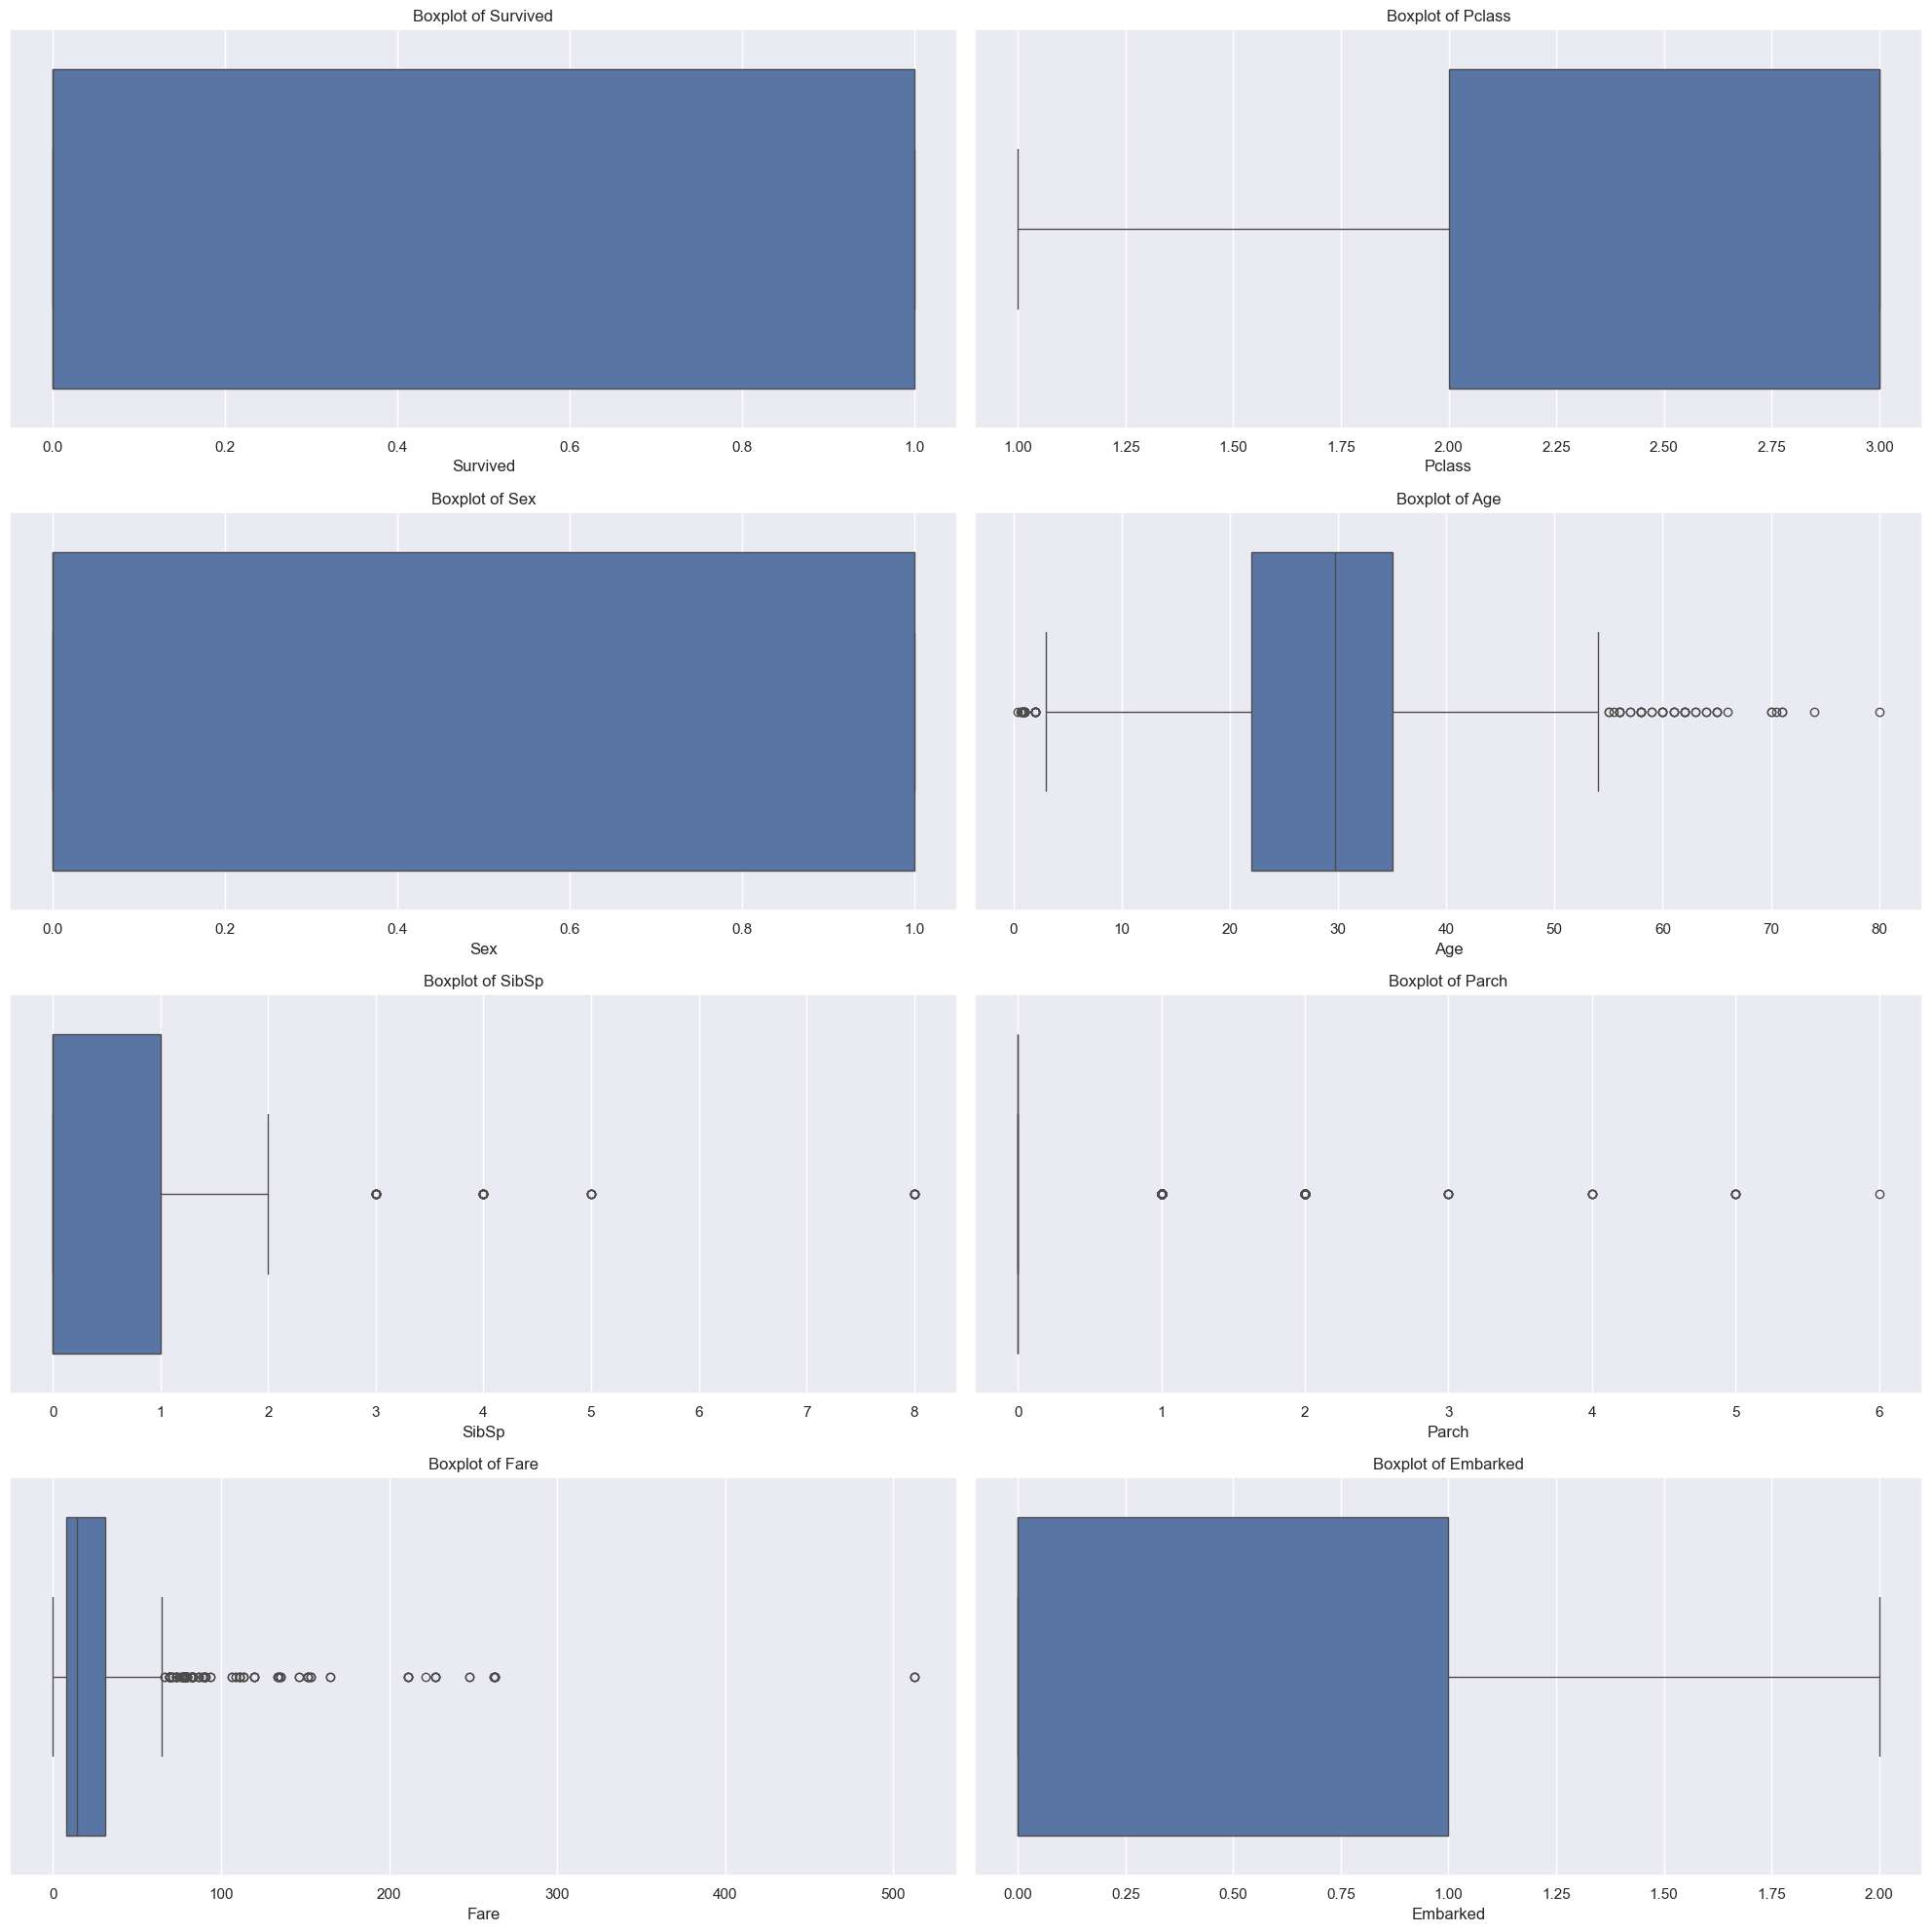

In [97]:
import math

# Get numeric columns from the DataFrame
numeric_cols = df.select_dtypes(exclude='object').columns

# Calculate the number of rows and columns required for subplots
num_cols = len(numeric_cols)
rows = math.ceil(num_cols / 2) 

fig, axes = plt.subplots(rows, 2, figsize=(20, 5 * rows))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[idx])
    axes[idx].set_title(f"Boxplot of {col}")

# Hide any unused axes
for i in range(num_cols, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [98]:
from sklearn.preprocessing import RobustScaler

numeric_columns = ['Age', 
               'Fare', 
               'Parch', 
               'SibSp',]

scaler = RobustScaler()
numeric_scaled_array = scaler.fit_transform(df[numeric_columns])
numeric_scaled_df = pd.DataFrame(numeric_scaled_array, columns=numeric_columns)

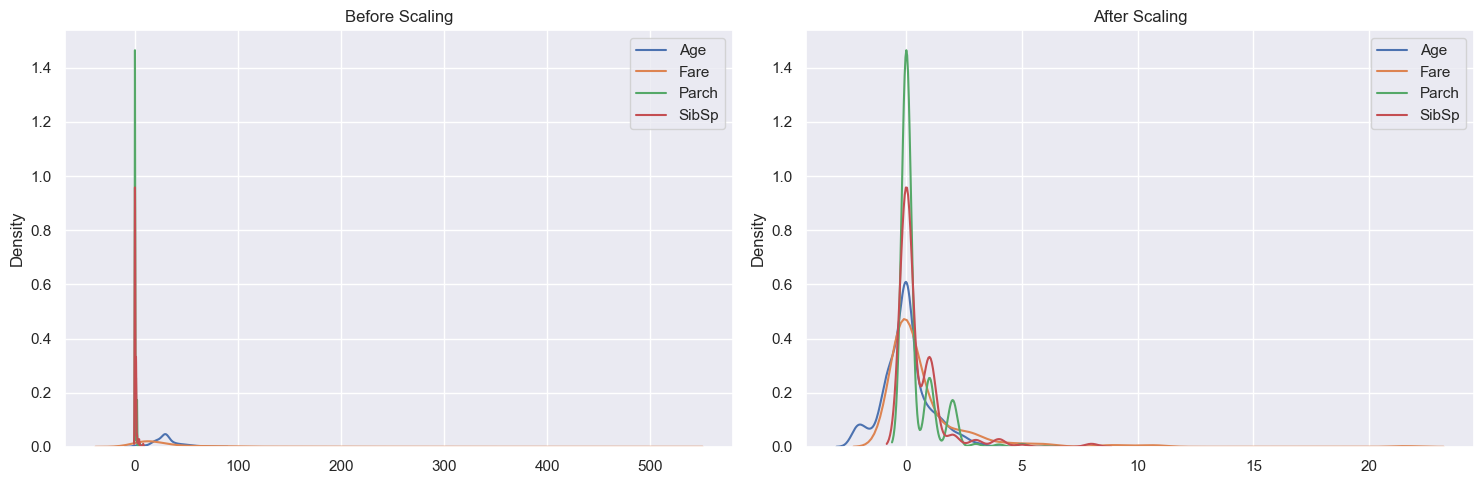

In [99]:
plt.figure(figsize=(15, 5))

# Plot Before Scaling
plt.subplot(121)
for column in numeric_columns:
    sns.distplot(df[column], hist=False, label=column)
plt.title('Before Scaling')
plt.xlabel('')
plt.legend()

# Plot After Scaling
plt.subplot(122)
for column in numeric_columns:
    sns.distplot(numeric_scaled_df[column], hist=False, label=column)
plt.title('After Scaling')
plt.xlabel('')
plt.legend()

plt.tight_layout()
plt.show()

### Handling Outliers with Winsorizing

## What is Winsorizing data?
Simply It's one way or method to get rid of outlier data in.

How it get rid of the outlier data is by replacing the data point or value that you defined as "outliers" by the nearest value that is still considered as non-outliers.

<div style="text-align: center;">
    <img src="https://github.com/user-attachments/assets/a704b713-5cd1-4f09-89c0-18fe9823eb72" alt="winsorizing" width="700">
</div>

For the above example, data that are in above upper bound (>60) are considered as outliers, therefore the value of it are being replaced by the upper bound value, which is 60.
Simple concept yet can improved your model accuracy and generalization better!!.

In [100]:
def winsorize(data, columns_to_winsorize):
 for col in columns_to_winsorize:
   if col not in data.columns or not pd.api.types.is_numeric_dtype(data[col]):
     continue
   lower_bound = data[col].quantile(0.01, interpolation= 'nearest')
   upper_bound = data[col].quantile(0.99, interpolation= 'nearest')

   data.loc[data[col] < lower_bound, col] = lower_bound
   data.loc[data[col] > upper_bound, col] = lower_bound

columns_to_winsorize = df[['Age', 
               'SibSp', 
               'Parch', 
               'Fare',]]
winsorize(df, columns_to_winsorize)

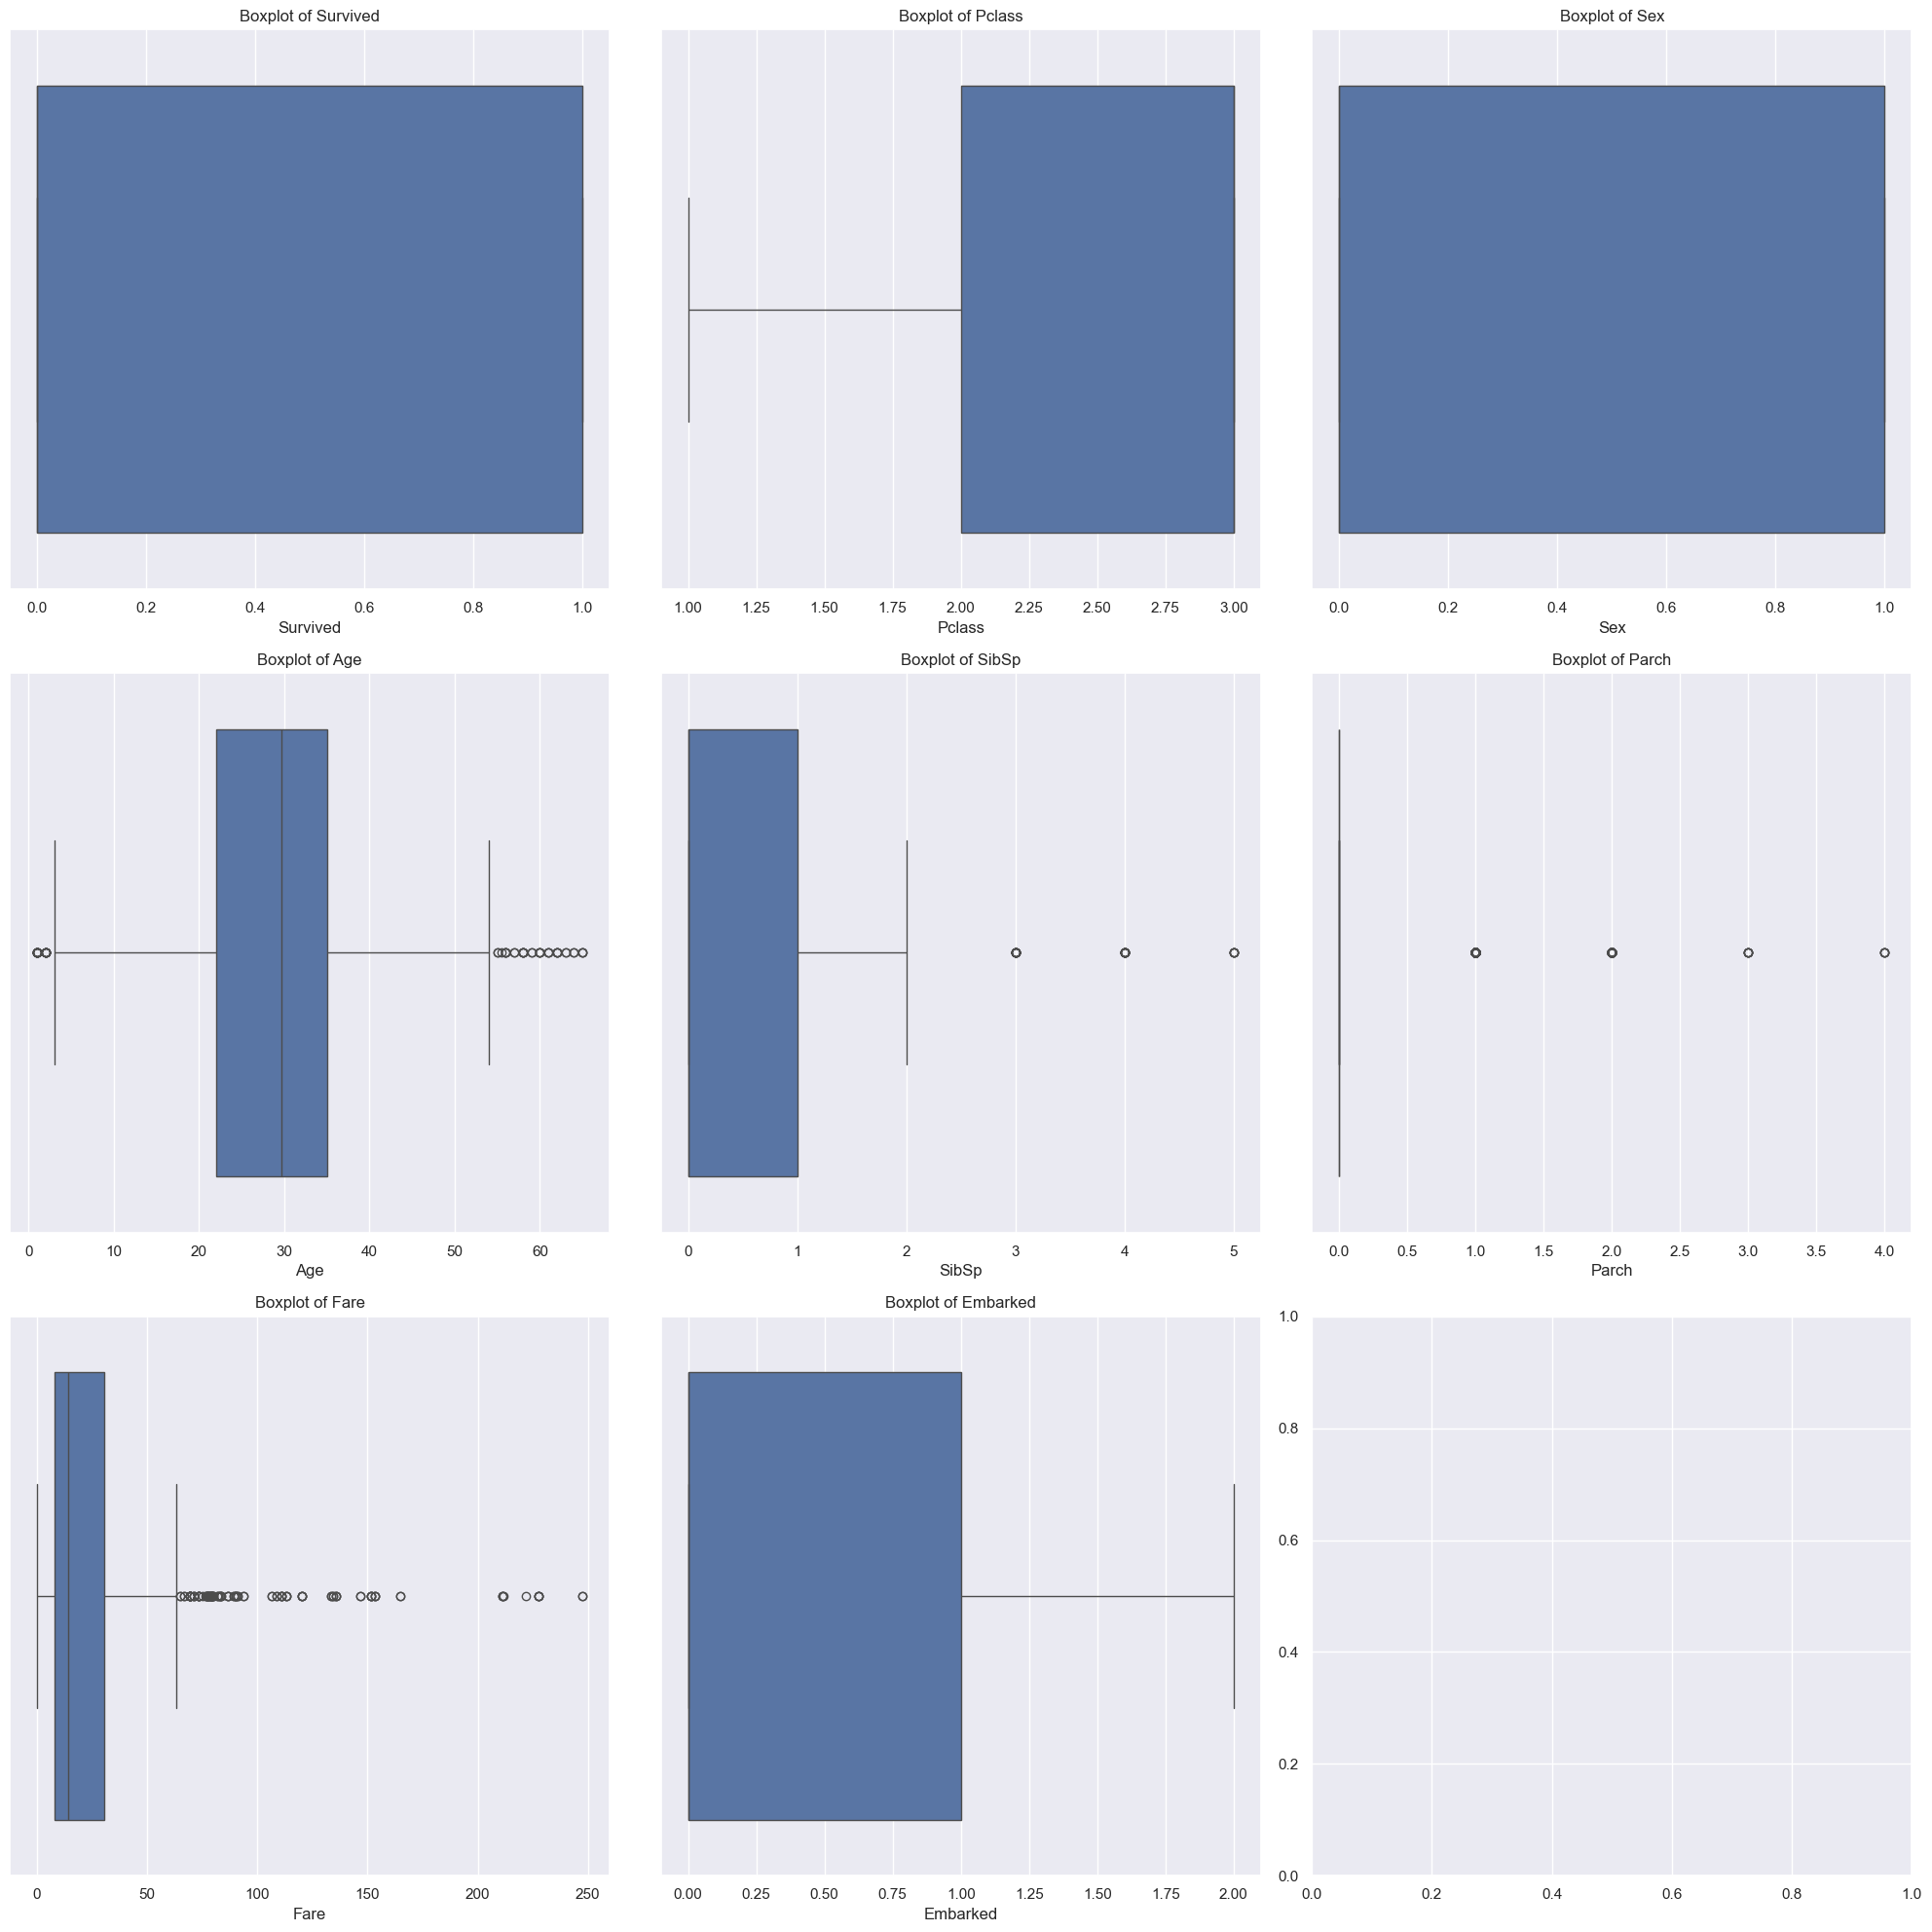

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
idx = 0

for i in df.select_dtypes(exclude='object'):
    sns.boxplot(x=df[i], ax=axes[idx])
    axes[idx].set_title(f"Boxplot of {i}")
    idx += 1

plt.tight_layout()
plt.show()

In [107]:
# Evaluasi Model
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=69),
    'Naive Bayes': GaussianNB()
}

metrics_dict = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# 10-fold cross-validation
kf = KFold(n_splits=10, random_state=42, shuffle=True)

fitted_models = {}

for name, model in models.items():
    # Cross-validation scores
    scores = cross_validate(
        model, X, Y, cv=kf, 
        scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    )
    
    # Average metrics across folds
    accuracy = scores['test_accuracy'].mean()
    precision = scores['test_precision_weighted'].mean()
    recall = scores['test_recall_weighted'].mean()
    f1 = scores['test_f1_weighted'].mean()

    # Save metrics
    metrics_dict['Model'].append(name)
    metrics_dict['Accuracy'].append(accuracy)
    metrics_dict['Precision'].append(precision)
    metrics_dict['Recall'].append(recall)
    metrics_dict['F1-Score'].append(f1)

    # Fit model to entire dataset for later use (if needed)
    model.fit(X, Y)
    fitted_models[name] = model

# Summarize results
metrics_df = pd.DataFrame(metrics_dict)
print("Metrics Summary:")
print(metrics_df.round(4).to_string(index=False))

Metrics Summary:
        Model  Accuracy  Precision  Recall  F1-Score
          KNN    0.6913     0.6883  0.6913    0.6865
Decision Tree    0.7834     0.7881  0.7834    0.7833
 RandomForest    0.8148     0.8163  0.8148    0.8136
  Naive Bayes    0.7890     0.7889  0.7890    0.7880


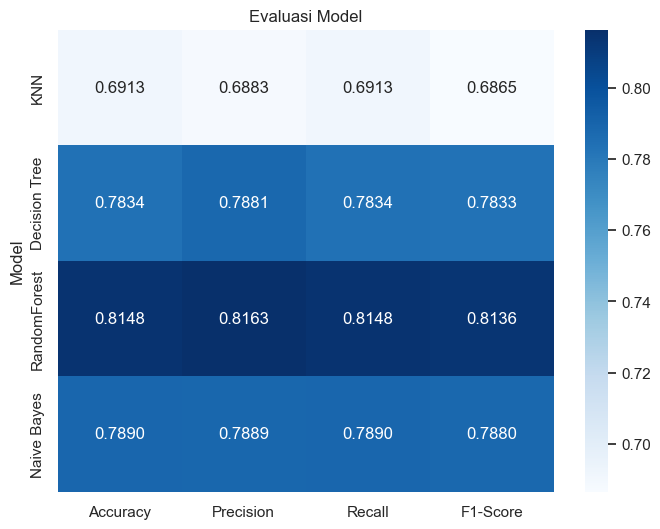

In [108]:
# Visualisasi dengan heatmap
plt.figure(figsize=(8, 6))
metrics_for_heatmap = metrics_df.set_index('Model')
sns.heatmap(metrics_for_heatmap, annot=True, cmap='Blues', fmt='.4f')
plt.title('Evaluasi Model')
plt.show()

# Hyperparameter Tuning

Let's try hyperparameter tuning to see the best possible paramaters that can be used on one of the best model existed for this case (RandomForestClassifier)

In [109]:
def objective(trial):
    # Adjusted hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 80, 200, step=20)
    max_depth = trial.suggest_int('max_depth', 10, 30, step=2) 
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3) 
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    # Create the model with suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=69
    )
    
    # 10-fold cross-validation
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, Y, cv=kf, scoring='accuracy')
    
    # Return the mean accuracy
    return scores.mean()

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust n_trials for more extensive search

# Print the best hyperparameters and the best accuracy
print("Best hyperparameters found by Optuna:")
print(study.best_params)
print(f"Best cross-validated accuracy: {study.best_value:.4f}")

# Evaluate the RandomForestClassifier with the best hyperparameters
best_params = study.best_params
best_rf = RandomForestClassifier(**best_params, random_state=69)

# Cross-validation evaluation with the tuned model
kf = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_validate(best_rf, X, Y, cv=kf, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

# Calculate metrics
accuracy = scores['test_accuracy'].mean()
precision = scores['test_precision_weighted'].mean()
recall = scores['test_recall_weighted'].mean()
f1 = scores['test_f1_weighted'].mean()

# Evaluate using the best parameters
metrics_dict = {
    'Model': ['Tuned RandomForest'],
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-Score': [f1]
}
metrics_df = pd.DataFrame(metrics_dict)
print("\nMetrics Summary:")
print(metrics_df.round(4).to_string(index=False))

[I 2024-11-18 21:53:42,171] A new study created in memory with name: no-name-d35ebc86-7b6b-4d89-83f0-4199608feeba
[I 2024-11-18 21:53:45,854] Trial 0 finished with value: 0.8249063670411985 and parameters: {'n_estimators': 160, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 0 with value: 0.8249063670411985.
[I 2024-11-18 21:53:49,431] Trial 1 finished with value: 0.8327465667915106 and parameters: {'n_estimators': 160, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 1 with value: 0.8327465667915106.
[I 2024-11-18 21:53:52,689] Trial 2 finished with value: 0.8282896379525594 and parameters: {'n_estimators': 140, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8327465667915106.
[I 2024-11-18 21:53:56,414] Trial 3 finished with value: 0.8327715355805243 and parameters: {'n_estimators': 160, 'max_depth': 28, 'min_sam

Best hyperparameters found by Optuna:
{'n_estimators': 120, 'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'criterion': 'entropy'}
Best cross-validated accuracy: 0.8339

Metrics Summary:
             Model  Accuracy  Precision  Recall  F1-Score
Tuned RandomForest    0.8339     0.8358  0.8339    0.8313


### Increased the accuracy to approximately 2%, can be better but improvement is an improvemnt so here it is about hyperparameter tuning!!